In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict

In [2]:
pt = pd.read_csv("/mnt/large/data/PersonTrip/関東都市圏/第６回（H３０）/01マスターデータ/MS2611.csv", encoding='cp932')
pt

,レコード区分,回収分類,バッチ番号,整理番号：市区町村,整理番号：ロット番号,整理番号：世帯ＳＱ,世帯人数／5歳未満含む,世帯人数／5歳未満除く,回収個人票数,現住所：完全桁数,...,トリップ時間（分）,滞在時間（分）,マストラ乗車：代表交通手段,マストラ乗車：駅コード（施設）,マストラ乗車：駅地点（ゾーン）,マストラ乗車：端末手段,マストラ降車：代表交通手段,マストラ降車：駅コード（施設）,マストラ降車：駅地点（ゾーン）,マストラ降車：端末手段
0,1,1,1,3108,1,18,2,2,2,7,...,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,3108,1,18,2,2,2,7,...,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,3108,1,18,2,2,2,7,...,30.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,1,3108,1,18,2,2,2,7,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,1,3108,1,58,2,2,2,7,...,20.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693078,2,2,999,9153,6,1731,2,99,1,7,...,49.0,NaN,5.0,1809.0,2914319.0,1.0,5.0,1709.0,810006.0,1.0
693079,1,2,999,9153,6,1753,2,99,1,7,...,30.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693080,2,2,999,9153,6,1753,2,99,1,7,...,30.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693081,2,2,999,9153,6,1753,2,99,1,7,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Assign individual files by demographics

In [7]:
path = '/mnt/large/data/PseudoPFLOW/ver2.0/Tokyo_PT_2018/'

for pid, person in pt.groupby(['整理番号：市区町村', '整理番号：ロット番号', '整理番号：世帯ＳＱ', '個人番号']):

    uid = f'{pid[0]:04}{pid[1]}{pid[2]:05}{pid[2]:02}'
   
    gender, age, occupation = person['性別'].iloc[0], person['年齢'].iloc[0], person['就業（形態・状況）'].iloc[0]
    
    directory = ''

    if occupation == 7:
        directory = 'student1/' if age < 19 else 'student2/'
    elif occupation in [2, 3, 4, 5]:
        directory = 'labor_male/' if gender == 1 else 'labor_female/'
    else:
        if age > 65:
            directory = 'nolabor_male_senior/' if gender == 1 else 'nolabor_female_senior/'
        else:
            directory = 'nolabor_male/' if gender == 1 else 'nolabor_female/'
    
    # print(directory, uid)
    if directory: 
        person.to_csv(f'{path}{directory}{uid}.csv', index=False)

## Temporal (15min) Activity Interpolation 

In [8]:
def survey_time_to_datetime(hour, minute, am_pm):
    if pd.isna(hour) or pd.isna(minute) or hour == 99 or minute == 99:
        return None
    hour, minute = int(hour), int(minute)
    if am_pm == 2 and hour < 12:
        hour += 12
    return datetime(2024, 1, 1, hour, minute)

# Define the mapping from activity numbers to their corresponding codes
activity_mapping = {str(key): value for key, value in {
    '1': '002', '2': '003', '3': '100', '4': '100', '5': '200', '6': '400',
    '7': '300', '8': '300', '9': '400', '10': '400', '11': '400', '12': '400',
    '13': '400', '14': '400', '15': '400', '16': '500', '17': '500', '18': '500',
    '19': '001', '20': '400', '0': '000'
}.items()}

In [9]:
def adjust_activity_for_overlapping_intervals_with_mapping(dataset):
    precise_activity_intervals = defaultdict(lambda: defaultdict(int))
    skip_file = False

    for _, trip in dataset.iterrows():
        try:
            purpose = str(int(trip['移動の目的'])) if not pd.isna(trip['移動の目的']) and trip['移動の目的'] != 99 else "0"
            start_time = survey_time_to_datetime(trip['出発時刻：時'], trip['出発時刻：分'], trip['出発時刻：午前・午後'])
            end_time = survey_time_to_datetime(trip['到着時刻：時'], trip['到着時刻：分'], trip['到着時刻：午前・午後'])

            if start_time and end_time:
                current_time = start_time - timedelta(minutes=start_time.minute % 15)
                while current_time < end_time:
                    interval_end = current_time + timedelta(minutes=15)
                    overlap_start = max(current_time, start_time)
                    overlap_end = min(interval_end, end_time)
                    overlap_duration = (overlap_end - overlap_start).total_seconds() / 60
                    if overlap_duration > 0:
                        precise_activity_intervals[current_time.strftime('%H:%M')][purpose] += overlap_duration
                    current_time += timedelta(minutes=15)
        except KeyError:
            print(f"KeyError encountered in file. Skipping file: {file_path}")
            return None

    resolved_schedule = {}
    for time_point, activities in precise_activity_intervals.items():
        main_activity = max(activities, key=lambda k: (activities[k], k != '0')) if activities else '0'
        resolved_schedule[time_point] = activity_mapping.get(main_activity, '000')

    for h in range(24):
        for m in range(0, 60, 15):
            time_slot = f"{h:02d}:{m:02d}"
            if time_slot not in resolved_schedule:
                resolved_schedule[time_slot] = '000'
                
    if resolved_schedule['00:00'] == '000':
        resolved_schedule['00:00'] = '001'

    return dict(sorted(resolved_schedule.items(), key=lambda x: datetime.strptime(x[0], '%H:%M')))

In [85]:
adjust_activity_for_overlapping_intervals_with_mapping(new_data)

{'00:00': '001',
 '00:15': '000',
 '00:30': '000',
 '00:45': '000',
 '01:00': '000',
 '01:15': '000',
 '01:30': '000',
 '01:45': '000',
 '02:00': '000',
 '02:15': '000',
 '02:30': '000',
 '02:45': '000',
 '03:00': '000',
 '03:15': '000',
 '03:30': '000',
 '03:45': '000',
 '04:00': '000',
 '04:15': '000',
 '04:30': '000',
 '04:45': '000',
 '05:00': '000',
 '05:15': '000',
 '05:30': '000',
 '05:45': '000',
 '06:00': '002',
 '06:15': '002',
 '06:30': '500',
 '06:45': '500',
 '07:00': '500',
 '07:15': '500',
 '07:30': '500',
 '07:45': '500',
 '08:00': '500',
 '08:15': '500',
 '08:30': '500',
 '08:45': '500',
 '09:00': '500',
 '09:15': '500',
 '09:30': '500',
 '09:45': '002',
 '10:00': '002',
 '10:15': '500',
 '10:30': '000',
 '10:45': '500',
 '11:00': '002',
 '11:15': '000',
 '11:30': '500',
 '11:45': '500',
 '12:00': '500',
 '12:15': '500',
 '12:30': '500',
 '12:45': '500',
 '13:00': '500',
 '13:15': '002',
 '13:30': '500',
 '13:45': '500',
 '14:00': '500',
 '14:15': '500',
 '14:30': '200

In [82]:
# def process_schedule_with_home_initial_and_continuity(dataset):
#     # Define the final schedule, starting with "Home" at 00:00
#     final_schedule = {datetime(2024, 1, 1, h, m).strftime('%H:%M'): 'null'  # '０' represents "Home", '97' represent 'stay'
#                       for h in range(24) for m in range(0, 60, 15)}
#     final_schedule['00:00'] = 0

#     # Process each trip in the dataset
#     for _, trip in dataset.iterrows():
#         start_time = survey_time_to_datetime(trip['出発時刻：時'], trip['出発時刻：分'], trip['出発時刻：午前・午後'])
#         end_time = survey_time_to_datetime(trip['到着時刻：時'], trip['到着時刻：分'], trip['到着時刻：午前・午後'])
#         purpose = str(trip['移動の目的']) # if '移動の目的' in dataset.columns and not pd.isna(trip['移動の目的']) else '1'

#         if start_time and end_time:
#             current_time = start_time
#             while current_time < end_time:
#                 time_slot = current_time.strftime('%H:%M')
#                 final_schedule[time_slot] = purpose
#                 current_time += timedelta(minutes=15)

#     # Fill in the gaps by propagating the last known activity forward
#     last_known_activity = '0'
#     for time_slot in sorted(final_schedule.keys()):
#         if final_schedule[time_slot] == 'null':  # If the activity is "Home", it might need to be updated
#             final_schedule[time_slot] = last_known_activity
#         else:
#             last_known_activity = final_schedule[time_slot]

#     return final_schedule

# new_data = pd.read_csv('/Users/pang/Data/PseudoPFLOW/ver2.0/Tokyo_PT_2018/labor_male/22165023012301.csv')

# # Process the dataset with the updated logic
# updated_final_schedule = process_schedule_with_home_initial_and_continuity(new_data)

# # Convert the schedule to a sorted list for display
# updated_final_schedule_items = sorted(updated_final_schedule.items(), key=lambda x: datetime.strptime(x[0], '%H:%M'))
# updated_final_schedule_items


[('00:00', 0),
 ('00:15', 0),
 ('00:30', 0),
 ('00:45', 0),
 ('01:00', 0),
 ('01:15', 0),
 ('01:30', 0),
 ('01:45', 0),
 ('02:00', 0),
 ('02:15', 0),
 ('02:30', 0),
 ('02:45', 0),
 ('03:00', 0),
 ('03:15', 0),
 ('03:30', 0),
 ('03:45', 0),
 ('04:00', 0),
 ('04:15', 0),
 ('04:30', 0),
 ('04:45', 0),
 ('05:00', 0),
 ('05:15', 0),
 ('05:30', 0),
 ('05:45', 0),
 ('06:00', '1.0'),
 ('06:15', '1.0'),
 ('06:30', '1.0'),
 ('06:40', '18.0'),
 ('06:45', '18.0'),
 ('06:57', '18.0'),
 ('07:00', '18.0'),
 ('07:03', '18.0'),
 ('07:08', '18.0'),
 ('07:12', '18.0'),
 ('07:14', '18.0'),
 ('07:15', '18.0'),
 ('07:20', '18.0'),
 ('07:29', '18.0'),
 ('07:30', '18.0'),
 ('07:39', '18.0'),
 ('07:44', '18.0'),
 ('07:45', '18.0'),
 ('07:48', '18.0'),
 ('07:54', '18.0'),
 ('08:00', '18.0'),
 ('08:09', '18.0'),
 ('08:15', '18.0'),
 ('08:20', '18.0'),
 ('08:30', '18.0'),
 ('08:41', '18.0'),
 ('08:45', '18.0'),
 ('08:49', '18.0'),
 ('09:00', '18.0'),
 ('09:04', '18.0'),
 ('09:15', '18.0'),
 ('09:16', '18.0'),
 ('

In [10]:
source_base_path = "/mnt/large/data/PseudoPFLOW/ver2.0/Tokyo_PT_2018/"
target_base_path = "/mnt/large/data/PseudoPFLOW/ver2.0/Markov/"

# Walk through the source directory
for root, dirs, files in os.walk(source_base_path):
    for file in files:
        if file == '.DS_Store':
            continue
        try: 
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path)
            final_schedule_with_mapping = adjust_activity_for_overlapping_intervals_with_mapping(data)

            if final_schedule_with_mapping is None:
                print(f"Skipped file due to '99': {file_path}")
                continue

            relative_path = os.path.relpath(root, source_base_path)
            target_dir = os.path.join(target_base_path, relative_path)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            target_file_path = os.path.join(target_dir, file)

            # Convert the schedule to a DataFrame and save as CSV
            pd.DataFrame.from_dict(final_schedule_with_mapping, orient='index', columns=['Activity']).to_csv(target_file_path, index_label='Time')
        except Exception as e:
            print(f"An error occurred while processing file {file_path}: {e}")
print("Processing completed.")

Processing completed.


## Time-dependent Markov Chain

In [28]:
def save_markov_chain(transition_probabilities, time_slots, states, output_file_path):
    with open(output_file_path, 'w') as f:
        for step, time_slot in enumerate(time_slots):  
            line = f"{step:03d},"
            for s1 in states[1:]:
                line = line + s1 + ' '
                for s2 in states:
                    line = line + s2 + ' ' + str(transition_probabilities[time_slot][states.index(s1)][states.index(s2)]) + ' '
                line += ','
            f.write(line.strip(' ,')+'\n')

In [30]:
states = ['000', '001', '002', '003', '100', '200', '300', '400', '500']
state_indices = {state: idx for idx, state in enumerate(states)}  
time_steps = [f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]

source_folder = '/mnt/large/data/PseudoPFLOW/ver2.0/Markov/'
target_folder = '/mnt/large/data/PseudoPFLOW/Processing/markov/'
dirs = ['student2', 'nolabor_male_senior', 'nolabor_female', 'nolabor_male', 'labor_male', 'nolabor_female_senior', 'student1', 'labor_female']

for folder in dirs:
    transition_counts_per_time_step = {time_step: np.zeros((len(states), len(states))) for time_step in time_steps}
    folder_path = os.path.join(source_folder, folder)
    
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path, dtype={'Time': str, 'Activity': str})
            data.sort_values(by='Time', inplace=True)

            previous_state = None
            data_length = len(data) - 1
            for i in range(data_length):
                current_state, next_state, time_step = data.iloc[i]['Activity'], data.iloc[i + 1]['Activity'], data.iloc[i]['Time']
                if current_state != '000':
                    previous_state = current_state

                if previous_state in state_indices and next_state in state_indices:
                    if previous_state == next_state:
                        next_state = '000'
                    previous_index, next_index = state_indices[previous_state], state_indices[next_state]
                    transition_counts_per_time_step[time_step][previous_index, next_index] += 1

    transition_probabilities_per_time_step = {}
    for time_step, counts in transition_counts_per_time_step.items():
        row_sums = counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1 
        probabilities = counts / row_sums
        transition_probabilities_per_time_step[time_step] = probabilities

    output_path = os.path.join(source_folder, f'tokyo2018_trip_{folder}_prob.csv')
    save_markov_chain(transition_probabilities_per_time_step, time_steps, states, output_path)

### Multi-process

In [58]:
from multiprocessing import Pool

In [59]:
def process_file(args):
    file_path, all_states, time_slots = args
    transition_counts = {time_slot: {state: {next_state: 0 for next_state in all_states} for state in all_states} for time_slot in time_slots}

    data = pd.read_csv(file_path, dtype={'Time': str, 'Activity': str})
    data.sort_values(by='Time', inplace=True)

    for i in range(len(data) - 1):
        current_time = data.iloc[i]['Time']
        next_time = data.iloc[i + 1]['Time']
        current_state = data.iloc[i]['Activity']
        next_state = data.iloc[i + 1]['Activity']

        time_slot = current_time[:5]
        if time_slot in transition_counts:
            transition_counts[time_slot][current_state][next_state] += 1

    return transition_counts

def merge_transition_counts(counts_list):
    merged_counts = counts_list[0]
    for counts in counts_list[1:]:
        for time_slot, state_counts in counts.items():
            for state, next_state_counts in state_counts.items():
                for next_state, count in next_state_counts.items():
                    merged_counts[time_slot][state][next_state] += count
    return merged_counts

def calculate_transition_probabilities(transition_counts, all_states, time_slots):
    transition_probabilities = {}
    for time_slot in time_slots:
        probabilities = np.zeros((len(all_states), len(all_states)))
        for i, state in enumerate(all_states):
            total_transitions = sum(transition_counts[time_slot][state].values())
            if total_transitions > 0:
                for j, next_state in enumerate(all_states):
                    probabilities[i, j] = transition_counts[time_slot][state][next_state] / total_transitions
            else:
                probabilities[i, i] = 1.0
        transition_probabilities[time_slot] = probabilities
    return transition_probabilities

In [60]:
all_states = ["000", "001", "002", "003", "100", "200", "300", "400", "500"]
time_slots = [f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]

source_folder = '/Users/pang/Data/PseudoPFLOW/ver2.0/Markov/student2'
file_paths = [os.path.join(root, f) for root, _, files in os.walk(source_folder) for f in files]
file_args = [(path, all_states, time_slots) for path in file_paths]

with Pool(processes=os.cpu_count()) as pool:
    results = pool.map(process_file, file_args)

merged_counts = merge_transition_counts(results)
transition_probabilities = calculate_transition_probabilities(merged_counts, all_states, time_slots)

Process SpawnPoolWorker-15:
Process SpawnPoolWorker-14:
Process SpawnPoolWorker-13:
Process SpawnPoolWorker-16:
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-18:
Traceback (most recent call last):
  File "/Users/pang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/pang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/pang/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/pang/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
  File "/Users/pang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: Can't get attribute 'process_file' on <module '__main__' (buil

KeyboardInterrupt: 

In [37]:
transition_counts_per_time_step 

{'00:00': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 '00:15': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 '00:30': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

In [ ]:
{-1=57236, 1=174488, 2=631053, 99=123208, 3=15154, 4=59386, 5=6056, 6=5117, 7=46387, 8=83, 9=351, 10=3533, 11=43195, 13=19, 15=32901}
{-1=57262, 1=174485, 2=692879, 3=34197, 99=1629, 4=158845, 5=21583, 6=3516, 7=29908, 8=116, 9=300, 10=551, 11=17891, 13=74, 15=4931}

In [ ]:
-1=15456, 1=104564, 2=646799, 3=44305, 99=13251, 4=188359, 5=34243, 6=14396, 7=64205, 8=265, 9=811, 10=3967, 11=47271, 13=420, 15=19855

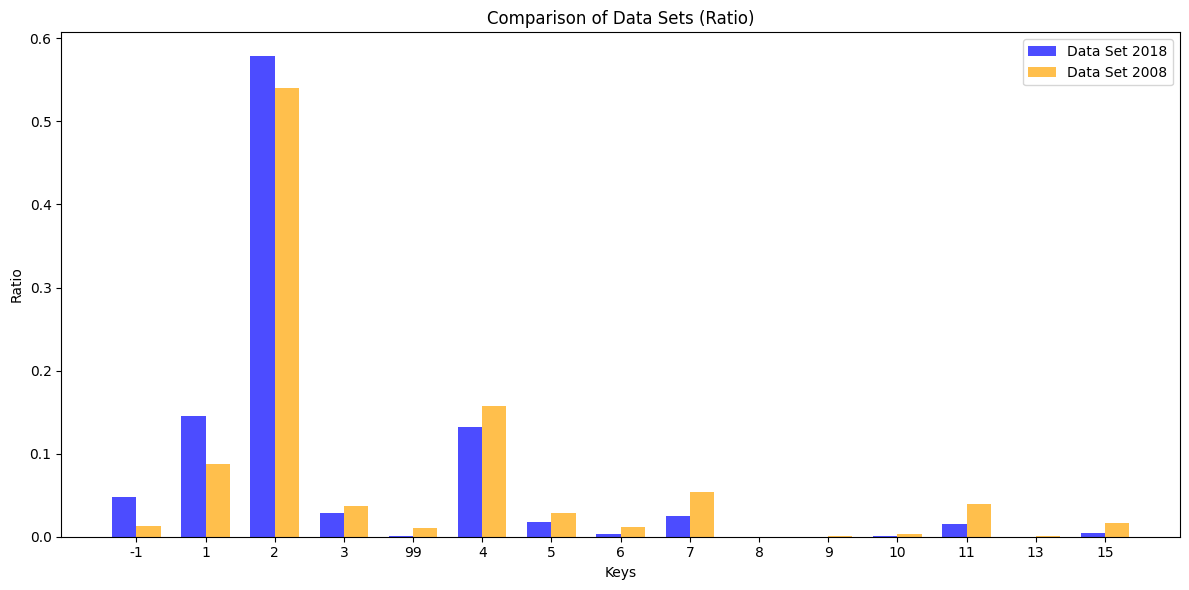

In [31]:
import matplotlib.pyplot as plt
import numpy as np

data1 ={-1:57262, 1:174485, 2:692879, 3:34197, 99:1629, 4:158845, 5:21583, 6:3516, 7:29908, 8:116, 9:300, 10:551, 11:17891, 13:74, 15:4931}
data2 = {-1: 15456, 1: 104564, 2: 646799, 3: 44305, 99: 13251, 4: 188359, 5: 34243, 6: 14396, 7: 64205, 8: 265, 9: 811, 10: 3967, 11: 47271, 13: 420, 15: 19855}

# Extract keys and corresponding values for each dataset
keys = list(data1.keys())
values1 = np.array([data1[key] for key in keys])
values2 = np.array([data2[key] for key in keys])

# Normalize the values to get proportions
values1_ratio = values1 / np.sum(values1)
values2_ratio = values2 / np.sum(values2)

# Plotting
bar_width = 0.35
index = np.arange(len(keys))

plt.figure(figsize=(12, 6))

plt.bar(index, values1_ratio, bar_width, label='Data Set 2018', color='blue', alpha=0.7)
plt.bar(index + bar_width, values2_ratio, bar_width, label='Data Set 2008', color='orange', alpha=0.7)

plt.xlabel('Keys')
plt.ylabel('Ratio')
plt.title('Comparison of Data Sets (Ratio)')
plt.xticks(index + bar_width / 2, keys)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
sum(data1.values()), sum(data2.values())

(1198167, 1198167)

In [16]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.1 MB/s eta 0:00:00m eta 0:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 56.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.9 MB/s eta 0:00:00


In [ ]:
tokyo2018: {-1=287907, 1=888135, 2=3503401, 3=176508, 99=8616, 4=809519, 5=107788, 6=17313, 7=153081, 8=700, 9=1416, 10=2698, 11=90863, 13=402, 15=25450}
tokyo2008: {-1=77256, 1=532062, 2=3270502, 3=226680, 99=66809, 4=963305, 5=168842, 6=71138, 7=327053, 8=1219, 9=4041, 10=19790, 11=240292, 13=1966, 15=102437}

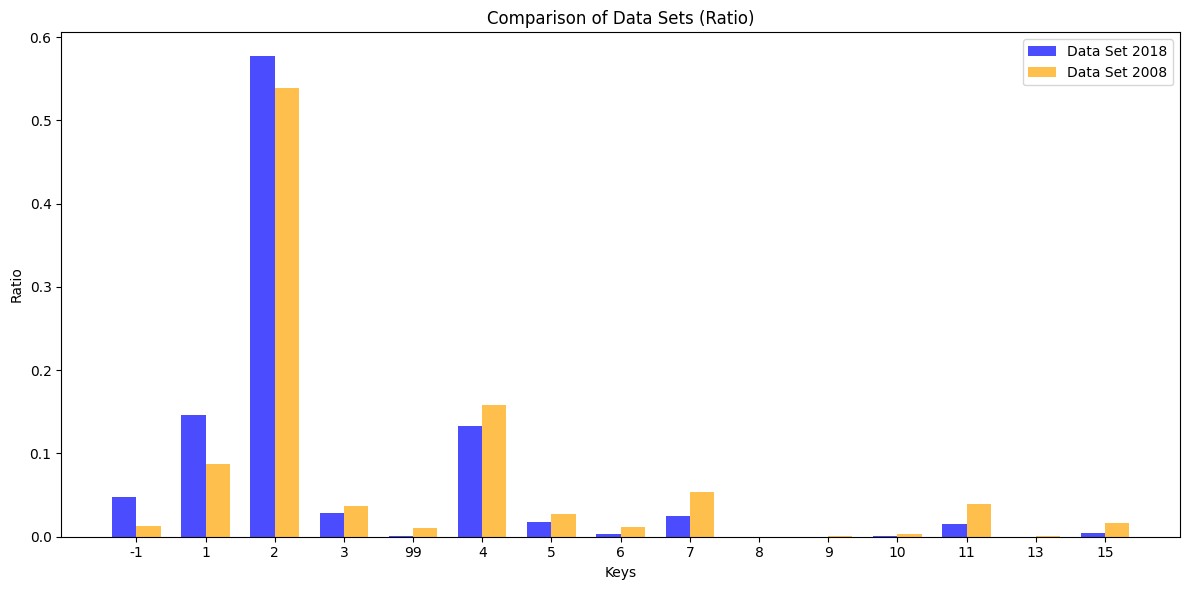

In [33]:
import matplotlib.pyplot as plt
import numpy as np

data1= {-1:287907, 1:888135, 2:3503401, 3:176508, 99:8616, 4:809519, 5:107788, 6:17313, 7:153081, 8:700, 9:1416, 10:2698, 11:90863, 13:402, 15:25450}
data2= {-1:77256, 1:532062, 2:3270502, 3:226680, 99:66809, 4:963305, 5:168842, 6:71138, 7:327053, 8:1219, 9:4041, 10:19790, 11:240292, 13:1966, 15:102437}

# Extract keys and corresponding values for each dataset
keys = list(data1.keys())
values1 = np.array([data1[key] for key in keys])
values2 = np.array([data2[key] for key in keys])

# Normalize the values to get proportions
values1_ratio = values1 / np.sum(values1)
values2_ratio = values2 / np.sum(values2)

# Plotting
bar_width = 0.35
index = np.arange(len(keys))

plt.figure(figsize=(12, 6))

plt.bar(index, values1_ratio, bar_width, label='Data Set 2018', color='blue', alpha=0.7)
plt.bar(index + bar_width, values2_ratio, bar_width, label='Data Set 2008', color='orange', alpha=0.7)

plt.xlabel('Keys')
plt.ylabel('Ratio')
plt.title('Comparison of Data Sets (Ratio)')
plt.xticks(index + bar_width / 2, keys)
plt.legend()

plt.tight_layout()
plt.show()